In [30]:
import csv
import math
import datetime
import numpy as np
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import log_loss
from dateutil.relativedelta import relativedelta

In [2]:
df_allmatch = pd.read_csv("./match_data_yearly/all_years.csv", index_col=0)
df_allmatch["Date"] = pd.to_datetime(df_allmatch["Date"])
df_allmatch

Year  Sec       Date                  Home                 Away  \
ID                                                                          
6010903   2006    1 2006-03-04           gamba-osaka   urawa-red-diamonds   
6012807   2006    1 2006-03-05        ventforet-kofu      shimizu-s-pulse   
6012231   2006    1 2006-03-05              fc-tokyo         oita-trinita   
6011323   2006    1 2006-03-05          jubilo-iwata       avispa-fukuoka   
6010820   2006    1 2006-03-05  nagoya-grampus-eight         cerezo-osaka   
...        ...  ...        ...                   ...                  ...   
20340120  2020   34 2020-12-19       kashima-antlers         cerezo-osaka   
20340810  2020   34 2020-12-19  nagoya-grampus-eight  sanfrecce-hiroshima   
20343331  2020   34 2020-12-19            sagan-tosu         oita-trinita   
20342218  2020   34 2020-12-19              fc-tokyo          vissel-kobe   
20340314  2020   34 2020-12-19    urawa-red-diamonds    consadole-sapporo   

          HomeID  AwayID  HomeGF  AwayGF  W/L Stadium  Attendances  HomeRate  \
ID                                                                             
6010903        9       3       1       1    0      万博        20916      1500   
6012807       28       7       0       2    2      小瀬        14277      1500   
6012231       22      31       2       0    1     味スタ        22531      1500   
6011323       13      23       1       1    0      静岡        28564      1500   
6010820        8      20       3       2    1     瑞穂陸        17199      1500   
...          ...     ...     ...     ...  ...     ...          ...       ...   
20340120       1      20       1       1    0     カシマ        11251      1594   
20340810       8      10       1       0    1     豊田ス        16825      1515   
20343331      33      31       2       2    0     駅スタ         8966      1453   
20342218      22      18       1       0    1     味スタ        14373      1540   
20340314       3      14       0       2    2      埼玉        19319      1485   

          AwayRate  HomeRD  AwayRD  
ID                                  
6010903       1500       0       0  
6012807       1500       0       0  
6012231       1500       0       0  
6011323       1500       0       0  
6010820       1500       0       0  
...            ...     ...     ...  
20340120      1560       4      -6  
20340810      1524       9     -13  
20343331      1458      17       7  
20342218      1453       8       0  
20340314      1458     -19       3  

[4590 rows x 16 columns]

### サッカーの得点数とポアソン分布の関係性

In [3]:
ave_score = (df_allmatch["HomeGF"].sum()+df_allmatch["AwayGF"].sum()) / (4590*2)
ave_score

1.361764705882353

In [4]:
scores = []
for s in  df_allmatch[["HomeGF","AwayGF"]].values:
    scores.extend(s)

In [5]:
actual = []
for i in range(9):
    actual.append(scores.count(i)/len(scores))

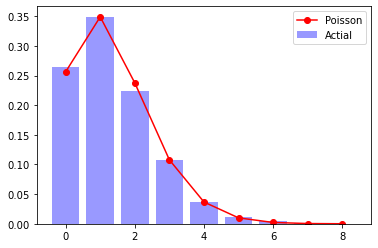

In [6]:
x =  np.arange(0, 9, 1)
plt.plot(x, poisson.pmf(x, ave_score), label='Poisson', marker='o',c ='r')
plt.bar(x, actual,  color="blue",alpha=0.4, label="Actial")

plt.legend()
plt.show()

06-20シーズンまでの1試合での1チームの平均得点数は1.36｡

上図の赤線が平均1.36得点起こる際の各得点別の確率をポワソン分布で算出して折れ線グラフにしたもの｡
青色の棒グラフが､実際に06-20シーズンでの1試合での1チームの得点数のヒストグラム｡

赤線と青の棒グラフを比較するとほぼ一致することがわかる｡

つまりサッカーの得点数がポアソン分布に従うと言える｡

---
### 攻撃力･守備力の算出

一定期間での各チームの得点･失点の平均をリーグの得点･失点の平均で割って比率を算出する｡
その比率(リーグ平均と比較して何倍得点しやすいか･失点しやすいか度合い)を攻撃力･守備力とみなす｡
攻撃力は多ければ得点数が多いのに対し､守備力は少なければ失点が少ない(≒強い)ことになる｡

平均データを取得する期間･範囲は直近5ヶ月とする｡
試合数で区切らないのはチームによって消化試合数が異なり､リーグ平均を出すのが困難なため｡

In [7]:
import datetime
from dateutil.relativedelta import relativedelta

In [8]:
match_id = 18290713	
date_range = 6

current_day = df_allmatch.at[match_id,"Date"]
home = df_allmatch.at[match_id,"Home"]
away = df_allmatch.at[match_id,"Away"]

df_recent = df_allmatch[
    (current_day-relativedelta(months=date_range) < df_allmatch["Date"] ) &
    (df_allmatch["Date"] < current_day) 
]

df_recent_home = df_recent[df_recent["Home"] == home]
df_recent_away = df_recent[df_recent["Away"] == away]

homegf_ave = df_recent_home["HomeGF"].mean()
homega_ave = df_recent_home["AwayGF"].mean()
awaygf_ave = df_recent_away["AwayGF"].mean()
awayga_ave = df_recent_away["HomeGF"].mean()
homegf_league_ave = df_recent["HomeGF"].mean()
awaygf_league_ave = df_recent["AwayGF"].mean()


print(f"{home}のホームでの平均得点 : {homegf_ave}")
print(f"{home}のホームでの平均失点 : {homega_ave}")
print(f"{away}のアウェイでの平均得点 : {awaygf_ave}")
print(f"{away}のアウェイでの平均失点 : {awayga_ave}")
print(f"リーグ全体のホームでの平均得点 : {homegf_league_ave}")
print(f"リーグ全体のアウェイでの平均得点 : {awaygf_league_ave}")

home_attack = homegf_ave / homegf_league_ave
away_defense = awayga_ave / homegf_league_ave
homegf_pred = home_attack * away_defense * homegf_league_ave

away_attack = awaygf_ave / awaygf_league_ave
home_defense = homega_ave / awaygf_league_ave
awaygf_pred = away_attack * home_defense * awaygf_league_ave

print(f"得点予測  {home} {homegf_pred:.2f} - {awaygf_pred:.2f} {away}")

shimizu-s-pulseのホームでの平均得点 : 1.6
shimizu-s-pulseのホームでの平均失点 : 1.4
jubilo-iwataのアウェイでの平均得点 : 1.0
jubilo-iwataのアウェイでの平均失点 : 1.1818181818181819
リーグ全体のホームでの平均得点 : 1.4656862745098038
リーグ全体のアウェイでの平均得点 : 1.2696078431372548
得点予測  shimizu-s-pulse 1.29 - 1.10 jubilo-iwata


In [9]:
# ホームチームの得点のしやすさ(攻撃力)
home_attack = homegf_ave / homegf_league_ave
home_attack

1.0916387959866223

In [10]:
#アウェイチームの失点のしやすさ(守備力)
away_defense = awayga_ave / homegf_league_ave
away_defense

0.8063241106719369

In [11]:
# アウェイチームの得点のしやすさ(攻撃力)
away_attack = awaygf_ave / awaygf_league_ave
away_attack

0.7876447876447877

In [12]:
# ホームチームの失点のしやすさ(守備力)
home_defense = homega_ave / awaygf_league_ave
home_defense

1.1027027027027028

### 得点予測

ホームチームの攻撃力にアウェイチームの守備力とリーグ全体のホームチームの平均ゴール数をかけることでホームチームの得点数を予測する｡(アウェイチームの得点数も同様)

平均から何倍得点しやすいか､失点しやすいかをそれぞれかけた値を予測値とする

In [13]:
#ホームチームの予想得点数
homegf_pred = home_attack * away_defense * homegf_league_ave
homegf_pred

1.2901185770750991

In [14]:
# アウェイチームの予想得点数
awaygf_pred = away_attack * home_defense * awaygf_league_ave
awaygf_pred

1.102702702702703

予測結果は1.29対1.10となった｡
上記の予測を平均値として､ポアソン分布で各スコア別の確率を出す

ex) 
1-0 20%
2-0 18%
1-1 13%
2-1 10% ...

### ポワソン分布で各スコアの確率を算出

J1での1試合の最多得点が9点であることから,ポワソン分布の幅を0-9点とし､10得点以上することはないと考えるが､10点得点以上のゲーム(0-10､10-10､15-20､､､､)の確率も存在してしまうため､最終的に予測した勝率､敗率､分率の和を割合にして､分母が100%になるようにする｡


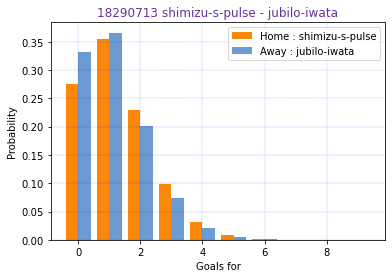

In [15]:
x =  np.arange(0, 10, 1)

home_poisson = poisson.pmf(x, homegf_pred)
away_poisson = poisson.pmf(x, awaygf_pred)


plt.bar(x, home_poisson, align="edge", width=-0.4,  color="#FA880A", label=f'Home : {home}')
plt.bar(x, away_poisson, align="edge", width= 0.4,  color="#6C9BD2", label=f'Away : {away}')

plt.xlabel('Goals for')
plt.ylabel('Probability')
plt.grid(color='b', linestyle=':', linewidth=0.3)
plt.title(f"{match_id} {home} - {away}", color='rebeccapurple')
plt.legend()
plt.show()


In [17]:
df_poisson = pd.DataFrame([home_poisson,away_poisson],columns=x, index=[home,away])
round(df_poisson,3)
# df_poisson

0      1      2      3      4      5      6    7    8  \
shimizu-s-pulse  0.275  0.355  0.229  0.099  0.032  0.008  0.002  0.0  0.0   
jubilo-iwata     0.332  0.366  0.202  0.074  0.020  0.005  0.001  0.0  0.0   

                   9  
shimizu-s-pulse  0.0  
jubilo-iwata     0.0

### 試合の勝,負,分の予測確率を出す

In [18]:
win_prob_sum = 0
loss_prob_sum = 0
draw_prob_sum = 0

for gf in x:
    gf_prob = df_poisson.at[home, gf]
    for ga in x:
        ga_prob = df_poisson.at[away,ga]
        score_prob = gf_prob * ga_prob
        
        if gf>ga:
            win_prob_sum += score_prob
        elif gf<ga:
            loss_prob_sum += score_prob
        else:
            draw_prob_sum += score_prob

In [19]:
prob_sum = win_prob_sum+loss_prob_sum+draw_prob_sum
prob_sum

0.999998634004885

In [20]:
win_prob_sum = win_prob_sum/prob_sum
loss_prob_sum = loss_prob_sum/prob_sum
draw_prob_sum = draw_prob_sum/prob_sum

In [21]:
win_prob_sum+loss_prob_sum+draw_prob_sum

1.0

In [22]:
print(f"{home} - {away}")
print(f"win {win_prob_sum:.2%}")
print(f"loss {loss_prob_sum:.2%}")
print(f"draw {draw_prob_sum:.2%}")

shimizu-s-pulse - jubilo-iwata
win 40.77%
loss 31.68%
draw 27.56%


In [23]:
df_allmatch.loc[18290713]

Year                          2018
Sec                             29
Date           2018-10-07 00:00:00
Home               shimizu-s-pulse
Away                  jubilo-iwata
HomeID                           7
AwayID                          13
HomeGF                           5
AwayGF                           1
W/L                              1
Stadium                       アイスタ
Attendances                  19159
HomeRate                      1447
AwayRate                      1497
HomeRD                          12
AwayRD                          -7
Name: 18290713, dtype: object

### 評価･考察

27.6/40.8/31.7というもっともらしい予測結果になった｡(試合結果は5-1) EloRatingで勝率を出すのとはぜんぜん違う感じになりそう｡Ratingは急激に上がらないのに対し､このポアソン分布は直近6ヶ月に絞っているので､直近の強さを可視化出来ている可能性がある｡

長期でこの手法の評価をするために以下で関数化する

### ===============================

In [24]:
def predict_with_poisson(match_id,date_range=6):
    
    current_day = df_allmatch.at[match_id,"Date"]
    home = df_allmatch.at[match_id,"Home"]
    away = df_allmatch.at[match_id,"Away"]

    df_recent = df_allmatch[
        (current_day-relativedelta(months=date_range) < df_allmatch["Date"] ) &
        (df_allmatch["Date"] < current_day) 
    ]

    df_recent_home = df_recent[df_recent["Home"] == home]
    df_recent_away = df_recent[df_recent["Away"] == away]

    homegf_ave = df_recent_home["HomeGF"].mean()
    homega_ave = df_recent_home["AwayGF"].mean()
    awaygf_ave = df_recent_away["AwayGF"].mean()
    awayga_ave = df_recent_away["HomeGF"].mean()
    homegf_league_ave = df_recent["HomeGF"].mean()
    awaygf_league_ave = df_recent["AwayGF"].mean()
    
    # 欠損値処理
    # 10-20までのJ2降格チームのホームとアウェイ別での平均得点と平均失点(0.99,1.66,0.94,1.83)で穴埋め       
    if  homegf_ave is np.nan:
        homegf_ave = 0.99
    if homega_ave is np.nan:
        homega_ave = 1.66
    if awaygf_ave is np.nan:
        awaygf_ave = 0.94
    if awayga_ave is np.nan:
        awayga_ave = 1.83

#     print(f"{home}のホームでの平均得点 : {homegf_ave}")
#     print(f"{home}のホームでの平均失点 : {homega_ave}")
#     print(f"{away}のアウェイでの平均得点 : {awaygf_ave}")
#     print(f"{away}のアウェイでの平均失点 : {awayga_ave}")
#     print(f"リーグ全体のホームでの平均得点 : {homegf_league_ave}")
#     print(f"リーグ全体のアウェイでの平均得点 : {awaygf_league_ave}")

    home_attack = homegf_ave / homegf_league_ave
    away_defense = awayga_ave / homegf_league_ave
    homegf_pred = home_attack * away_defense * homegf_league_ave

    away_attack = awaygf_ave / awaygf_league_ave
    home_defense = homega_ave / awaygf_league_ave
    awaygf_pred = away_attack * home_defense * awaygf_league_ave
    
    

#     print(f"得点予測  {home} {homegf_pred:.2f} - {awaygf_pred:.2f} {away}")
    
    x =  np.arange(0, 10, 1)
    home_poisson = poisson.pmf(x, homegf_pred)
    away_poisson = poisson.pmf(x, awaygf_pred)

#     plt.bar(x, home_poisson, align="edge", width=-0.4,  color="#FA880A", label=f'Home : {home}')
#     plt.bar(x, away_poisson, align="edge", width= 0.4,  color="#6C9BD2", label=f'Away : {away}')

#     plt.xlabel('Goals for')
#     plt.ylabel('Probability')
#     plt.grid(color='b', linestyle=':', linewidth=0.3)
#     plt.title(f"{match_id} {home} - {away}", color='rebeccapurple')
#     plt.legend()
#     plt.show()
    
    df_poisson = pd.DataFrame([home_poisson,away_poisson],columns=x, index=[home,away])
    
    win_prob_sum = 0
    loss_prob_sum = 0
    draw_prob_sum = 0

    for gf in x:
        gf_prob = df_poisson.at[home, gf]
        for ga in x:
            ga_prob = df_poisson.at[away,ga]
            score_prob = gf_prob * ga_prob

            if gf>ga:
                win_prob_sum += score_prob
            elif gf<ga:
                loss_prob_sum += score_prob
            else:
                draw_prob_sum += score_prob
                
    prob_sum = win_prob_sum+loss_prob_sum+draw_prob_sum
    win_prob_sum = win_prob_sum/prob_sum
    loss_prob_sum = loss_prob_sum/prob_sum
    draw_prob_sum = draw_prob_sum/prob_sum
    
#     print(f"{home} - {away}")
#     print(f"draw(0) {draw_prob_sum:.2%} win(1) {win_prob_sum:.2%} loss(2) {loss_prob_sum:.2%}")
    
    return draw_prob_sum,win_prob_sum,loss_prob_sum
                

In [25]:
predict_with_poisson(20011834)

(0.14773264939935163, 0.7480294081075571, 0.10423794249309132)

### 長期間で予測･評価

#### 勝敗予測

In [32]:
loglosses = []
accuracies = []
draw_pred_count = 0
draw_correct_count = 0

for y in range(2013,2021):
    df_pred = pd.DataFrame(index=df_allmatch[df_allmatch["Year"] == y].index, columns=[0,1,2,"pred","actual"])

    pred_winrate_sum=0 # 予測勝率の和
    actual_win_sum=0 # 実勝利数の和

    pred_drawrate_sum=0 # 予測引き分け率の和
    actual_draw_sum=0 # 実引き分け数の和

    pred_lossrate_sum=0 # 予測敗率の和
    actual_loss_sum=0 # 実敗北数の和

    error_squares = []
    correct_count = 0
    
    y_test = []
    y_pred_proba = []

    for index, row in df_pred.iterrows():   

        d_pred = predict_with_poisson(index)[0]
        w_pred = predict_with_poisson(index)[1]
        l_pred = predict_with_poisson(index)[2]

        if max(predict_with_poisson(index)) == w_pred:
            wl_pred = 1
        elif max(predict_with_poisson(index)) == l_pred:
            wl_pred = 2
        else:
            wl_pred = 0
            draw_pred_count += 1

        actual = df_allmatch.at[index, "W/L"]
        

        row[0] = d_pred
        row[1] = w_pred
        row[2] = l_pred
        row["pred"] = wl_pred
        row["actual"] = actual
        
        y_pred_proba.append([d_pred,w_pred,l_pred])
        y_test.append(actual)
        
        if wl_pred == actual:
            correct_count += 1
            if actual == 0:
                draw_correct_count += 1

        if wl_pred == 1:
            pred_winrate_sum += w_pred
            pred_lossrate_sum += l_pred
            pred_drawrate_sum += d_pred

            if actual == 1:
                actual_win_sum += 1
            elif actual == 0:
                actual_draw_sum += 1
            else:
                actual_loss_sum += 1

        elif wl_pred == 2:
            pred_winrate_sum += l_pred
            pred_lossrate_sum += w_pred
            pred_drawrate_sum += d_pred

            if actual == 2:
                actual_win_sum += 1
            elif actual == 0:
                actual_draw_sum += 1
            else:
                actual_loss_sum += 1
    
    logloss = log_loss(y_test,y_pred_proba,labels=[0,1,2])
    loglosses.append(logloss)

    calibration = pred_winrate_sum/actual_win_sum
    error_square = ((1-calibration)*100)**2
    error_squares.append(error_square)
    accuracies.append(correct_count/len(df_pred))
    

print(f"的中率(Accuracy)の平均値 : {np.mean(accuracies):.3f}" )
print(f"対数損失(Log loss)の平均値 : {np.mean(loglosses):.3f}" )
print(f"誤差の2乗の平均値 : {np.mean(error_squares):.3f} (平方根:{math.sqrt(np.mean(error_squares)):.3f}) " )




的中率(Accuracy)の平均値 : 0.451
対数損失(Log loss)の平均値 : 1.442
誤差の2乗の平均値 : 429.794 (平方根:20.731) 


In [33]:
print(f"{draw_pred_count}試合予測 / {draw_correct_count}試合的中")
print("引き分け的中率 :" + str(draw_correct_count / (df_allmatch[(df_allmatch["Year"] >= 2013) & (df_allmatch["W/L"]==0)]).shape[0]))

142試合予測 / 36試合的中
引き分け的中率 :0.06293706293706294


In [34]:
(df_allmatch[(df_allmatch["Year"] >= 2013) & (df_allmatch["W/L"]==0)]).shape[0]

572

13-20年での的中率45%となり､機械学習を用いた的中率と比較してわずかに減少した｡どの手法を使っても50%いかないぐらいの的中率になりそう…｡

これまでの手法との違いは引きわけを予測すること｡2448試合中142試合引き分けを予測した｡またそのうち36試合を的中させた｡
全引き分け試合572試合中の6%的中｡

Loglossに関しては,1.442と大きな誤差を生んでしまっている.
改善案としては,平均得点/失点の取る範囲を一定にすること(5試合分ぐらい). 今は直近半年としておりそれだと取得範囲に大小が生じ,少ないところだと,1試合のみから平均を取る(もはや平均ではない)みたいな形になってしまっている.また平均得点/失点に0があると勝率換算したときに0になってしまうのも誤差を大きく生んでしまっている要因(これはすべてが悪いことではなく,はっきりと反映される分,RFとは違う予測を出せる).

totoでも同様に検証する

#### toto予測

In [39]:
df_pred = pd.DataFrame(index=df_allmatch[df_allmatch["Year"] >= 2013].index, columns=[0,1,2,"pred","actual"])

for index, row in df_pred.iterrows():

    d_pred = predict_with_poisson(index)[0]
    w_pred = predict_with_poisson(index)[1]
    l_pred = predict_with_poisson(index)[2]

    if max(predict_with_poisson(index)) == w_pred:
        wl_pred = 1
    elif max(predict_with_poisson(index)) == l_pred:
        wl_pred = 2
    else:
        wl_pred = 0
        draw_pred_count += 1

    actual = df_allmatch.at[index, "W/L"]


    row[0] = d_pred
    row[1] = w_pred
    row[2] = l_pred
    row["pred"] = wl_pred
    row["actual"] = actual

In [40]:
df_price =  pd.DataFrame([[100,300,900,2700,8100,24300],[200,600,1800,5400,16200],[400,1200,3600,10800],[800,2400,7200],[1600,4800],[3200]], columns=['t_0','t_1','t_2','t_3','t_4','t_5'], index = ['d_0','d_1','d_2','d_3','d_4','d_5'])
pay_back_rates = 0
sum_total_profit = 0
pay_back_rates = 0
for year in range(2013,2021):

    df_toto = pd.read_csv(f"./toto_data/{year}.csv", header=[0,1], index_col=[0,1])
    df_toto.rename(columns={'Unnamed: 2_level_1':'','Unnamed: 3_level_1':''}, level=1, inplace=True)
    df_pred = df_pred

    total_amount = 0
    total_profit = 0
    total_winning = 0
    for index,row in df_toto.iterrows():

        amount = 0
        d_count = 0
        t_count = 0

        buy_lots = []

        for i in range(1,6):
            m_id = row[(f"Match{i}","MatchID")] # これを引数で関数化する
            pred = df_pred.loc[m_id]

            # 買い方を返す
            buy_lot = []
            if pred[1] - pred[2] >= 0.04:
                buy_lot = [1]
            elif pred[1] - pred[2] > -0.04:
                buy_lot = [0,1,2]
            else:
                buy_lot = [2]

            if len(buy_lot) == 3:
                t_count += 1
            elif len(buy_lot) == 2:
                d_count += 1
            elif len(buy_lot) == 0:
                buy_lot = [0,1,2]
                t_count += 1

            buy_lots.append(buy_lot)

        amount = int(df_price.iloc[d_count,t_count])

        # 実際に買っていたときの結果を出力
        winning = row[("Winning","")]
        is_winning = True
        for i in range(1,6):
            m_wl = row[(f"Match{i}","W/L")]
            if not m_wl in buy_lots[i-1]:
                is_winning = False


        if is_winning:
            profit = winning - amount
            total_winning += winning
        else:
            profit = amount * (-1)

        total_amount += amount
        total_profit += profit
        
        pay_back_rate = total_winning / total_amount

        

    print(f"{year}年 総購入金額 : {total_amount}円 総利益 : {total_profit}円 回収率 : {Decimal(pay_back_rate):.02}") 
    pay_back_rates += pay_back_rate
    sum_total_profit+=total_profit
print(f"平均回収率 {Decimal(pay_back_rates)/8:.02} ")
print(f"8年間の総利益 {sum_total_profit}円")

2013年 総購入金額 : 8400円 総利益 : 10657円 回収率 : 2.3
2014年 総購入金額 : 6200円 総利益 : -1012円 回収率 : 0.84
2015年 総購入金額 : 5800円 総利益 : -5800円 回収率 : 0
2016年 総購入金額 : 5800円 総利益 : -5060円 回収率 : 0.13
2017年 総購入金額 : 4200円 総利益 : -2912円 回収率 : 0.31
2018年 総購入金額 : 6500円 総利益 : -36円 回収率 : 0.99
2019年 総購入金額 : 4800円 総利益 : -4800円 回収率 : 0
2020年 総購入金額 : 9200円 総利益 : -2396円 回収率 : 0.74
平均回収率 0.66 
8年間の総利益 -11359円


### 指摘された問題点
* (攻撃力) × (守備力) × (リーグ平均得点) で得点数を算出する手法で予測スコアを出すと､予測スコアの平均が実際の平均と異なってしまう問題｡
* 閾値の決定が未来のデータまで考慮してしまっている(↓のような感じで)

In [41]:
df_price =  pd.DataFrame([[100,300,900,2700,8100,24300],[200,600,1800,5400,16200],[400,1200,3600,10800],[800,2400,7200],[1600,4800],[3200]], columns=['t_0','t_1','t_2','t_3','t_4','t_5'], index = ['d_0','d_1','d_2','d_3','d_4','d_5'])
pay_back_rates = 0
sum_total_profit = 0
pay_back_rates = 0

for th in range(0,100,5):
    th = th/100
    pay_back_rates = 0
    sum_total_profit = 0
    for year in range(2013,2021):

        df_toto = pd.read_csv(f"./toto_data/{year}.csv", header=[0,1], index_col=[0,1])
        df_toto.rename(columns={'Unnamed: 2_level_1':'','Unnamed: 3_level_1':''}, level=1, inplace=True)
        df_pred = df_pred

        total_amount = 0
        total_profit = 0
        total_winning = 0
        for index,row in df_toto.iterrows():

            amount = 0
            d_count = 0
            t_count = 0

            buy_lots = []

            for i in range(1,6):
                m_id = row[(f"Match{i}","MatchID")] # これを引数で関数化する
                pred = df_pred.loc[m_id]

                # 買い方を返す
                buy_lot = []
                if pred[1] - pred[2] >= th:
                    buy_lot = [1]
                elif pred[1] - pred[2] > (-1)*th:
                    buy_lot = [0,1,2]
                else:
                    buy_lot = [2]

                if len(buy_lot) == 3:
                    t_count += 1
                elif len(buy_lot) == 2:
                    d_count += 1
                elif len(buy_lot) == 0:
                    buy_lot = [0,1,2]
                    t_count += 1

                buy_lots.append(buy_lot)

            amount = int(df_price.iloc[d_count,t_count])

            # 実際に買っていたときの結果を出力
            winning = row[("Winning","")]
            is_winning = True
            for i in range(1,6):
                m_wl = row[(f"Match{i}","W/L")]
                if not m_wl in buy_lots[i-1]:
                    is_winning = False


            if is_winning:
                profit = winning - amount
                total_winning += winning
            else:
                profit = amount * (-1)

            total_amount += amount
            total_profit += profit

            pay_back_rate = total_winning / total_amount



#         print(f"{year}年 総購入金額 : {total_amount}円 総利益 : {total_profit}円 回収率 : {Decimal(pay_back_rate):.02}") 
        pay_back_rates += pay_back_rate
        sum_total_profit+=total_profit
    print(f"閾値:{th} 平均回収率:{Decimal(pay_back_rates)/8:.02} 8年間の総利益:{sum_total_profit}円")

閾値:0.0 平均回収率:0.49 8年間の総利益:-13187円
閾値:0.05 平均回収率:0.65 8年間の総利益:-13650円
閾値:0.1 平均回収率:0.43 8年間の総利益:-54513円
閾値:0.15 平均回収率:0.29 8年間の総利益:-112860円
閾値:0.2 平均回収率:0.44 8年間の総利益:-143048円
閾値:0.25 平均回収率:0.67 8年間の総利益:-155580円
閾値:0.3 平均回収率:0.57 8年間の総利益:-301532円
閾値:0.35 平均回収率:0.51 8年間の総利益:-514716円
閾値:0.4 平均回収率:0.50 8年間の総利益:-705244円
閾値:0.45 平均回収率:0.54 8年間の総利益:-857287円
閾値:0.5 平均回収率:0.55 8年間の総利益:-1036862円
閾値:0.55 平均回収率:0.62 8年間の総利益:-1120109円
閾値:0.6 平均回収率:0.60 8年間の総利益:-1428786円
閾値:0.65 平均回収率:0.58 8年間の総利益:-1743309円
閾値:0.7 平均回収率:0.60 8年間の総利益:-1902536円
閾値:0.75 平均回収率:0.61 8年間の総利益:-2041256円
閾値:0.8 平均回収率:0.60 8年間の総利益:-2210892円
閾値:0.85 平均回収率:0.60 8年間の総利益:-2344085円
閾値:0.9 平均回収率:0.59 8年間の総利益:-2454177円
閾値:0.95 平均回収率:0.58 8年間の総利益:-2560863円


In [42]:
df_price =  pd.DataFrame([[100,300,900,2700,8100,24300],[200,600,1800,5400,16200],[400,1200,3600,10800],[800,2400,7200],[1600,4800],[3200]], columns=['t_0','t_1','t_2','t_3','t_4','t_5'], index = ['d_0','d_1','d_2','d_3','d_4','d_5'])
pay_back_rates = 0
sum_total_profit = 0
sum_total_amount=0
pay_back_rates = 0
for year in range(2013,2021):

    df_toto = pd.read_csv(f"./toto_data/{year}.csv", header=[0,1], index_col=[0,1])
    df_toto.rename(columns={'Unnamed: 2_level_1':'','Unnamed: 3_level_1':''}, level=1, inplace=True)
    df_pred = df_pred

    total_amount = 0
    total_profit = 0
    total_winning = 0
    for index,row in df_toto.iterrows():

        amount = 0
        d_count = 0
        t_count = 0

        buy_lots = []

        for i in range(1,6):
            m_id = row[(f"Match{i}","MatchID")] # これを引数で関数化する
            pred = df_pred.loc[m_id]

            # 買い方を返す
            buy_lot = []
            if pred[1] - pred[2] >= 0.1:
                buy_lot = [1]
            elif pred[1] - pred[2] > -0.1:
                buy_lot = [1,2]
            else:
                buy_lot = [2]

            if len(buy_lot) == 3:
                t_count += 1
            elif len(buy_lot) == 2:
                d_count += 1
            elif len(buy_lot) == 0:
                buy_lot = [0,1,2]
                t_count += 1

            buy_lots.append(buy_lot)

        amount = int(df_price.iloc[d_count,t_count])

        # 実際に買っていたときの結果を出力
        winning = row[("Winning","")]
        is_winning = True
        for i in range(1,6):
            m_wl = row[(f"Match{i}","W/L")]
            if not m_wl in buy_lots[i-1]:
                is_winning = False


        if is_winning:
            profit = winning - amount
            total_winning += winning
        else:
            profit = amount * (-1)

        total_amount += amount
        total_profit += profit
        
        pay_back_rate = total_winning / total_amount
        
        if total_profit > total_amount:
            print("Break!")
            break


    print(f"{year}年 総購入金額 : {total_amount}円 総利益 : {total_profit}円 回収率 : {Decimal(pay_back_rate):.02}") 
    pay_back_rates += pay_back_rate
    sum_total_profit+=total_profit
    sum_total_amount += total_amount
print(f"平均回収率 {(sum_total_profit+sum_total_amount)/sum_total_amount:.02} ")
print(f"8年間の総利益 {sum_total_profit}円(購入金額{sum_total_amount})円")

2013年 総購入金額 : 9900円 総利益 : -9900円 回収率 : 0
2014年 総購入金額 : 5600円 総利益 : -1979円 回収率 : 0.65
2015年 総購入金額 : 7300円 総利益 : -6207円 回収率 : 0.15
2016年 総購入金額 : 6300円 総利益 : -4704円 回収率 : 0.25
2017年 総購入金額 : 4900円 総利益 : -3612円 回収率 : 0.26
Break!
2018年 総購入金額 : 1300円 総利益 : 3432円 回収率 : 3.6
2019年 総購入金額 : 4900円 総利益 : -4900円 回収率 : 0
Break!
2020年 総購入金額 : 900円 総利益 : 3908円 回収率 : 5.3
平均回収率 0.42 
8年間の総利益 -23962円(購入金額41100)円


ペイできた瞬間にその年の購入をやめてみると,,,微妙